In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('cars.csv')
print("Dataset info:", df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6308 entries, 0 to 6307
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   car name         6308 non-null   object
 1   price            6308 non-null   object
 2   engine_capacity  6308 non-null   object
 3   cylinder         5684 non-null   object
 4   horse_power      6308 non-null   object
 5   top_speed        6308 non-null   object
 6   seats            6308 non-null   object
 7   brand            6308 non-null   object
 8   country          6308 non-null   object
dtypes: object(9)
memory usage: 443.7+ KB
Dataset info: None


In [2]:
import pandas as pd
import numpy as np

# Function to extract currency and amount from the price string
def extract_currency_and_price(price):
    if isinstance(price, str):
        parts = price.strip().split()
        

        if len(parts) == 2 and len(parts[0]) == 3:
            currency = parts[0]
            try:
                amount = float(parts[1].replace(',', ''))
                return currency, amount
            except ValueError:
                return None, None
        else:
            return None, None
    else:
        return None, None


df = pd.read_csv('cars.csv')


df[['Currency', 'Amount']] = df['price'].apply(lambda x: pd.Series(extract_currency_and_price(x)))
df.dropna(subset=['Amount'], inplace=True)

# Conversion rates to USD
conversion_rates = {
    'USD': 1.0,      # US Dollar
    'SAR': 0.27,     # Saudi Riyal
    'EGP': 0.032,    # Egyptian Pound
    'BHD': 2.65,     # Bahraini Dinar
    'QAR': 0.27,     # Qatari Riyal
    'OMR': 2.6,      # Omani Rial
    'KWD': 3.3,      # Kuwaiti Dinar
    'AED': 0.27,     # UAE Dirham
}



df['Price_USD'] = df.apply(lambda row: row['Amount'] * conversion_rates.get(row['Currency'], np.nan), axis=1)



df.drop(columns=['price', 'Currency', 'Amount'], inplace=True)
df.to_csv('processed_cars_data.csv', index=False)
print("Data saved to 'processed_cars_data.csv'")


Unique currencies: [None 'SAR' 'EGP' 'BHD' 'QAR' 'OMR' 'KWD' 'AED']
Data saved to 'processed_cars_data.csv'


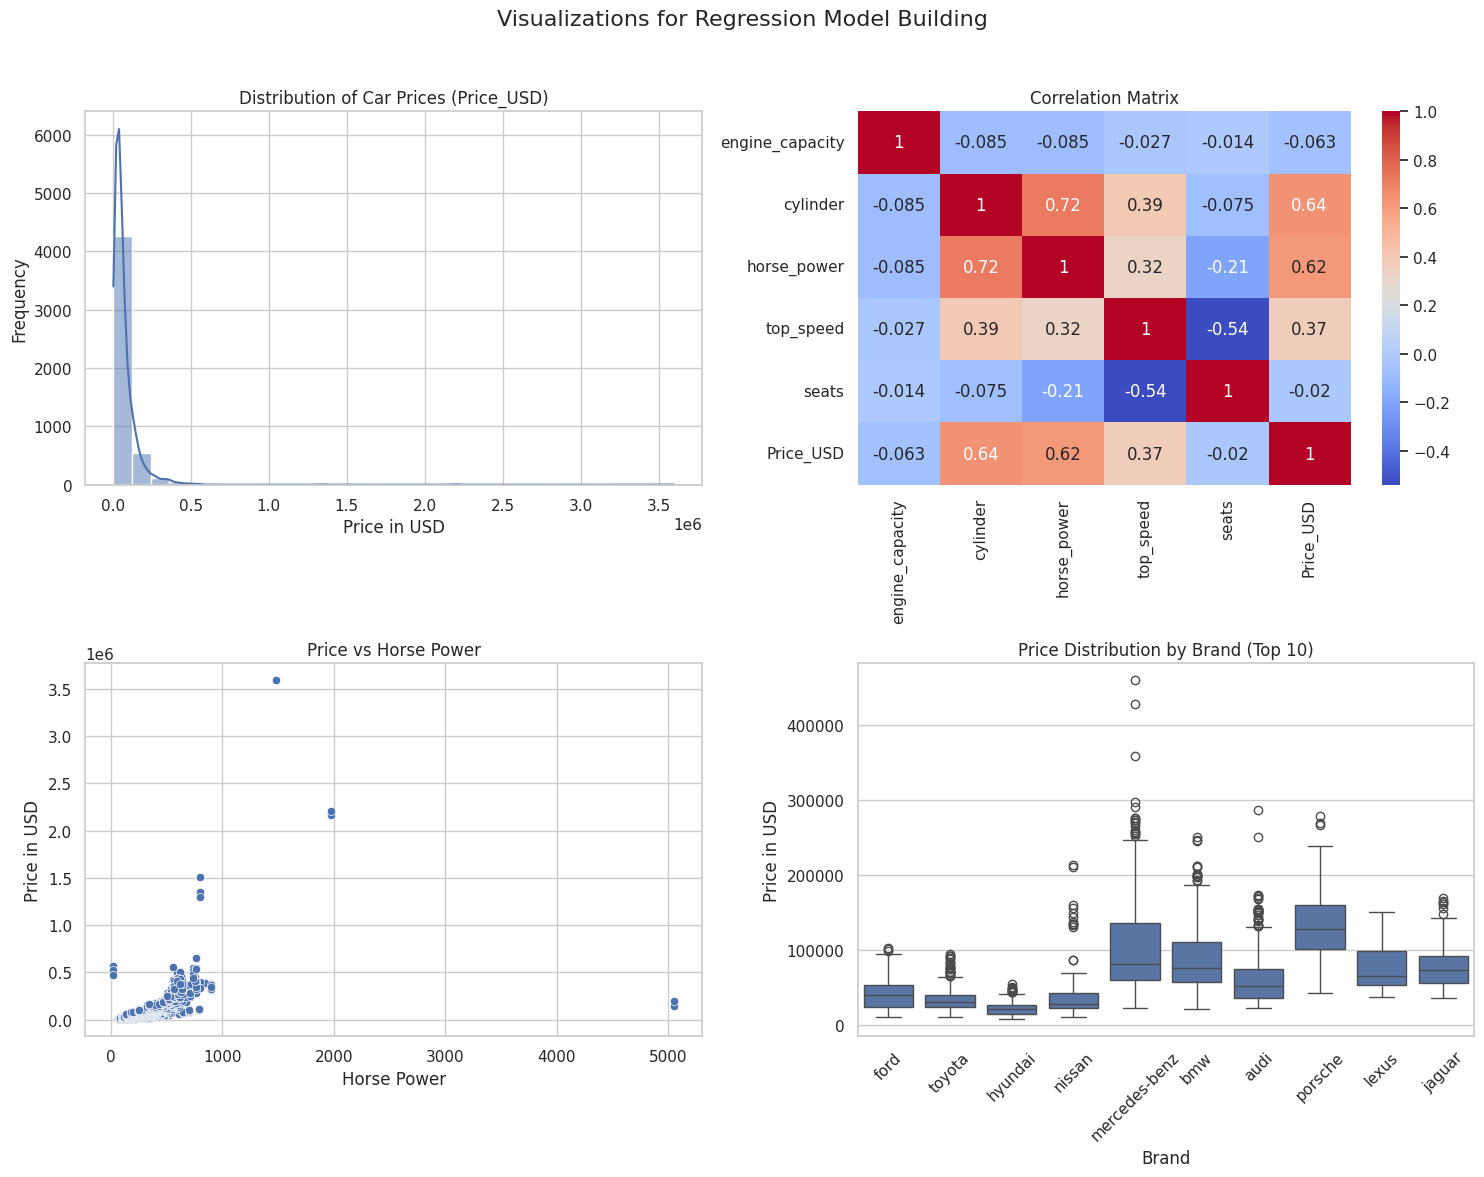

In [4]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
file_path = 'processed_cars_data.csv'  # Update with the path if different
cars_data = pd.read_csv(file_path)

# Data Cleaning: Convert relevant columns to numeric
def clean_numeric(column):
    return pd.to_numeric(cars_data[column].replace(r'[^\d.]', '', regex=True), errors='coerce')

# Apply cleaning to relevant columns
cars_data['engine_capacity'] = clean_numeric('engine_capacity')
cars_data['cylinder'] = clean_numeric('cylinder')
cars_data['horse_power'] = clean_numeric('horse_power')
cars_data['top_speed'] = clean_numeric('top_speed')
cars_data['seats'] = clean_numeric('seats')

# Set up the plotting style
sns.set(style="whitegrid")

# Initialize a figure with multiple subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Visualizations for Regression Model Building', fontsize=16)

# 1. Price Distribution
sns.histplot(cars_data['Price_USD'], bins=30, kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Distribution of Car Prices (Price_USD)')
axs[0, 0].set_xlabel('Price in USD')
axs[0, 0].set_ylabel('Frequency')

# 2. Correlation Heatmap
correlation_matrix = cars_data[['engine_capacity', 'cylinder', 'horse_power', 'top_speed', 'seats', 'Price_USD']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=axs[0, 1])
axs[0, 1].set_title('Correlation Matrix')

# 3. Scatter Plot: Price vs Horse Power
sns.scatterplot(data=cars_data, x='horse_power', y='Price_USD', ax=axs[1, 0])
axs[1, 0].set_title('Price vs Horse Power')
axs[1, 0].set_xlabel('Horse Power')
axs[1, 0].set_ylabel('Price in USD')

# 4. Box Plot of Prices by Brand (Top 10 Brands by Count)
top_brands = cars_data['brand'].value_counts().index[:10]
sns.boxplot(data=cars_data[cars_data['brand'].isin(top_brands)], x='brand', y='Price_USD', ax=axs[1, 1])
axs[1, 1].set_title('Price Distribution by Brand (Top 10)')
axs[1, 1].set_xlabel('Brand')
axs[1, 1].set_ylabel('Price in USD')
axs[1, 1].tick_params(axis='x', rotation=45)

# Display the plots
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
